# Image Reconstruction using Variational Autoencoders (VAE)

> Indented block



<b> <div style="text-align: right">[TOTAL POINTS: 10]</div></b>
## Learning Objective
In this assignment, we will be implementing VAE to reconstruct the Fashion MNIST images. 

1. Create the encoder model.
2. Create the decoder model.
3. Implement KL-Divergence Loss on VAE Model.
4. Train the VAE model.
5. Visualize original image, latent space and reconstructed image.


## Dataset Description

### Fashion MNIST Dataset

*Source* : https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE<br>
*Author* : Zalando SE<br>
*License* : Copyright © 2017 Zalando SE, https://tech.zalando.com<br>

This dataset consists of 60000 28x28 grayscale images of 10 categories of fashion clothings. The categories are 'T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag' and 'Ankle Boot'. Likewise, there are 10000 test images. 

Dataset   $\hspace{20mm}$   No of images<br>
Train Set$\hspace{25mm}$ 60000<br>
Test Set  $\hspace{25mm}$ 20000<br>


## Import required libraries

In [2]:
### READ ONLY 
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load Dataset

### Dataset Preparation Steps

1. The Fashion MNIST dataset is loaded from `torchvision.datasets.MNIST`
2. The dataset contains pixel that take value from 0 to 1. So we don't have to perform normalization by dividing the train and test images by 255.0. 

In [3]:
### READ ONLY
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, download=True,
                                           transform=transform)
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, download=True,
                                          transform=transform)
print("Examples in train and test set:", len(train_dataset), len(test_dataset))
image_shape = train_dataset[0][0].shape
print("Image shape(channels, height, width):", image_shape)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Examples in train and test set: 60000 10000
Image shape(channels, height, width): torch.Size([1, 28, 28])


In [4]:
### READ ONLY
batch_size = 128 #Batch_size per iteration

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
len(trainloader), len(testloader)

(469, 79)

In [5]:
### READ ONLY

class Sampling(nn.Module):
  """
  Class for sampling latent vector(z), the vector encoding of the digits using z_mean and z_log_var
  
  Methods
  --------
  forward(z_mean, z_log_var)
      computes the deterministic latent space variable
      
    """


  def forward(self, z_mean, z_log_var):
    """
    computes the deterministic latent space variable
    
    Parameters
    ---------
    z_mean: Tensor
        mean values of the approximate posterior probability
        
    z_log_var: Tensor
        log_scale values of the variance of the approximate posterior probability
        
    Returns
    -------
    z:Tensor
        deterministic latent space variable
    """
    stddev = torch.exp(0.5*z_log_var)
    epsilon = torch.randn_like(stddev)
    return z_mean + stddev*epsilon

## Exercise 1: Create Encoder Model

**[Points: 4]**

**Task** : Implement Encoder Model such that it returns mean, log-variance and latent space.

**Steps** : 
1. Inside sequential module add following layers in order
    * 2D convolution with `in_channels=image_shape[0]`, `out_channels=32`, `5 x 5 kernels`, `stride of 1`, `padding=2`
    * ReLU activation
    * 2D convolution with `in_channels=32`, `out_channels=32`, `4 x 4 kernels`, `stride of 2`, `padding=1`
    * ReLU activation
    * 2D convolution with `in_channels=32`, `out_channels=64`, `4 x 4 kernels`, `stride of 2`, `padding=1`
    * ReLU activation
    * Flatten the output
    * Linear layer with `in_features=prod(out_channels of last conv layer; 64, image height//4, image width//4)`
    * ReLU activation
2. Implement forward method with following operation in order
    * Call sequential layer created in step 1 passing inputs
    * Pass the output to mean and log_var layer and store output in variables `z_mean` and `z_log_var` respectively
    * Call sampling layer and store result in variable `z`

### Solution Code Snippet
<details>
    <summary style="color:red">Click here and copy the code to cell below</summary>
    
        self.enc_layers = nn.Sequential(
          
            nn.Conv2d(None, None, kernel_size=None, stride=None, padding=None), # out_shape = image_shape
            nn.ReLU(),
            nn.Conv2d(None, None, kernel_size=None, stride=None, padding=None), # out_shape = image_shape//2
            nn.ReLU(),
            nn.Conv2d(None, None, kernel_size=None, stride=None, padding=None), # out_shape = image_shape//4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(None, None),
            nn.ReLU(),
          
        )

        self.dense_mean = nn.Linear(196, latent_dim)
        self.dense_log_var = nn.Linear(196, latent_dim)
        self.sampling = Sampling()
    
    def forward(self, inputs):
        
        """
        Forward pass for encoder network
        
        Parameters
        ----------
        inputs: Tensor
                Input data to the encoder network
        
        Returns
        -------
        z_mean: Tensors 
            mean values of the approximate posterior probability
        z_log_var: Tensors 
            log_scale values of the variance of the approximate posterior probability
        z: Tensors
            deterministic latent space variables, output of the encoder network
        """        
        z_mean, z_log_var, z = None, None, None
        
        h = None                #Type your code here
        z_mean = None           #Type your code here
        z_log_var = None        #Type your code here
        z = None                #Type your code here

</details>

In [6]:
### Ex-1-Task-1

class Encoder(nn.Module):
    """Generates (z_mean, z_log_var, z) from Fashion MNIST"""

    """
    Encoder of VAE network
    
    Properties
    ---------- 
    latent_dim: int
            size of latent dim vector in which image will be encoded
    image_shape: Tuple or torch.Size
            size of an image in the format: (Channels, Height, Weight)
            
    
    inputs: Tensor or numpy.ndarray
            input data to the encoder network
        
    Methods
    -------
    forward(inputs)
        Forward pass for encoder network
    """
     
    def __init__(self,
                 image_shape,
                 latent_dim,
                ):
        super(Encoder, self).__init__()

        self.enc_layers = nn.Sequential(
            
            nn.Conv2d(image_shape[0], 32, kernel_size=5, stride=1, padding=2), # out_shape = image_shape
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1), # out_shape = image_shape//2
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # out_shape = image_shape//4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(image_shape[1]//4)*(image_shape[2]//4), 196),
            nn.ReLU(),
            
        )

        self.dense_mean = nn.Linear(196, latent_dim)
        self.dense_log_var = nn.Linear(196, latent_dim)
        self.sampling = Sampling()
    
    def forward(self, inputs):
        
        """
        Forward pass for encoder network
        
        Parameters
        ----------
        inputs: Tensor
                Input data to the encoder network
        
        Returns
        -------
        z_mean: Tensors 
            mean values of the approximate posterior probability
        z_log_var: Tensors 
            log_scale values of the variance of the approximate posterior probability
        z: Tensors
            deterministic latent space variables, output of the encoder network
        """        
        z_mean, z_log_var, z = None, None, None
        ### BEGIN SOLUTION
        # your code here
        out = self.enc_layers(inputs)
        z_mean = self.dense_mean(out)
        z_log_var = self.dense_log_var(out)
        z = self.sampling(z_mean=z_mean,z_log_var=z_log_var)
        ### END SOLUTION

        return z_mean, z_log_var, z

In [7]:
### READ ONLY
latent_dim = 16
encoder_ = Encoder(image_shape, latent_dim).to(device)
encoder_

Encoder(
  (enc_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=196, bias=True)
    (8): ReLU()
  )
  (dense_mean): Linear(in_features=196, out_features=16, bias=True)
  (dense_log_var): Linear(in_features=196, out_features=16, bias=True)
  (sampling): Sampling()
)

In [8]:
### Intentionally left blank

## Exercise 2: Create Decoder Model

**[Points: 4]**

Implement Decoder Model according to following details.

**Task**
1. Initialise a Linear layer with in_features `latent_dim` and out_features `64*(image_height//4)*(image_width//4)`.
2. Relu Activation
3. Reshape the previous layer into `(64, image_height//4, image_width//4)`. Use the `Reshape` Module defined in the cell below.
4. Implement 2D convolution tranpose(`nn.ConvTranspose2d`) with `(in_channels, out_channels, kernel, stride, padding)=(64, 32, 4, 2, 1)`
5. Relu Activation
6. Implement 2D convolution tranpose with `(in_channels, out_channels, kernel, stride, padding)=(32, 32, 4, 2, 1)`
7. Relu Activation
8. Implement 2D convolution tranpose with `(in_channels, out_channels, kernel, stride, padding)=(32, image_shape[0], 5, 1, 2)`
9. Sigmoid Activation
10. Implement `forward` method passing the inputs to the Sequential module implemented with above layers.

In [9]:
### Ex-2-Task-1

class Reshape(nn.Module):
    """
    Reshape the image to target shape, ignores the batching dim=0
    """
    def __init__(self, target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape
    
    def forward(self, inputs):
        return inputs.view((-1, *self.target_shape))

class Decoder(nn.Module):
    """
    Reconstructs Fashion MNIST from latent variable obtained from Encoder

    Decoder of VAE network
    
    Properties
    ----------    
    latent_dim : int
        No.of nodes of the latent space representation
    dense_dim  : int
        The product of the shape of the output obtained from last convolution layer of Encoder Model.
        The decoder converts latent space to that dense shape
    reshape_dim: 
        The shape of the output obtained from last convolution layer of Encoder Model.
        The decoder reshapes the previous shape to reshape_dim

        
    Methods
    -------
    forward(inputs)
        Forward pass for decoder network
        
    """
    def __init__(self,
                 image_shape,
                 latent_dim,
                 ):
        super(Decoder, self).__init__()
        # self.image_shape=image_shape
        # self.latent_dim=latent_dim
        # self.height=image_shape[1]
        # self.width=image_shape[2]
        
        """
        Task: Initialize the variables as stated above.
        
        """

        self.dec_layers = nn.Sequential(
            ### BEGIN SOLUTION
            # your code here
            nn.Linear(latent_dim,64*(image_shape[1]//4)*(image_shape[2]//4)),
            nn.ReLU(),
            
            Reshape((64, image_shape[1]//4, image_shape[2]//4)),
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32,kernel_size= 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_shape[0], kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
            ### END SOLUTION
        )
        
    def forward(self, inputs):
        
        """
        Forward pass for decoder network
        
        Parameters
        ----------
        
        inputs: Tensor
            input data(latent space features) to the decoder network.
            
        Returns
        -------
        x : Tensor
            output of the decoder network. Reconstructed output.
        """
        

        x = self.dec_layers(inputs)


        return x

In [10]:
### READ ONLY

decoder_ = Decoder(image_shape=image_shape,
                   latent_dim=latent_dim).to(device)
decoder_

Decoder(
  (dec_layers): Sequential(
    (0): Linear(in_features=16, out_features=3136, bias=True)
    (1): ReLU()
    (2): Reshape()
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): Sigmoid()
  )
)

In [ ]:
### Intentionally left blank


## Create VAE Model 

In [11]:
### READ ONLY
class VAE(nn.Module):
    """
    Takes encoder and decoder model, and perform end-to-end image reconstruction
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs):
        reconstructed, z_mean, z_log_var = None, None, None

        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        return reconstructed, z_mean, z_log_var

In [12]:
### READ ONLY
vae_ = VAE(encoder_, decoder_).to(device)
vae_

VAE(
  (encoder): Encoder(
    (enc_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=3136, out_features=196, bias=True)
      (8): ReLU()
    )
    (dense_mean): Linear(in_features=196, out_features=16, bias=True)
    (dense_log_var): Linear(in_features=196, out_features=16, bias=True)
    (sampling): Sampling()
  )
  (decoder): Decoder(
    (dec_layers): Sequential(
      (0): Linear(in_features=16, out_features=3136, bias=True)
      (1): ReLU()
      (2): Reshape()
      (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (

In [13]:
# READ ONLY

test_inp = torch.randn((10,*image_shape), device=device)
test_reconstructed, test_z_mean, test_z_log_var=vae_(test_inp)

assert test_reconstructed.shape == (10, *image_shape), "Invalid mean shape"
assert test_z_mean.shape == (10,latent_dim), "Invalid mean shape"
assert test_z_log_var.shape == (10,latent_dim), "Invalid log-variance shape"


## Exercise 3: KL Divergence Loss

**[Points: 2]**

**Task** : Implement KL-Divergence Loss

### KL Divergence loss formula to be implemented.

$$\text{KL}(N(\mu,\sigma))=-\frac{1}{2}(1+ln(\sigma^2)-\sigma^2-\mu^2)$$

**Aside from above formula, the loss should be averaged along the batch dimension. Also note that we pass log(variance) to the function below. Adjust the formula above accordingly.**


In [14]:
### Ex-3-Task-1

def KLDivLoss(mean, log_var):
    """
    Implement KL div loss for Normal distribution with Standard Normal Distribution as reference probability distirbution

    Params
    ----------------------
    mean: Tensor
        mean tensor of candidate probability ditribution; shape: (Batch Size, Latent dim)
    
    log_var: Tensor
        log variance of the candidate probability distribution; shape: (Batch Size, Latent dim)

    Returns
    -----------------------
    Tensor
        average KL divergence loss for the batch of inputs; shape: Scalar Tensor
    """
    loss = None
    ### BEGIN SOLUTION
    # your code here
    var = torch.exp(log_var)
    loss = -.5*(1+log_var-2.718281828459**log_var-mean**2)
    loss=torch.sum(loss)/log_var.shape[0]
    ### END SOLUTION
    return loss

In [ ]:
### Intentionally left blank


## Traning the VAE

In [21]:
### READ ONLY
learning_rate = 5e-4
num_epochs = 20
reconstruction_loss_object = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(vae_.parameters(), lr=learning_rate)

In [22]:
### READ ONLY

reconstruction_losses_avg = []
kl_divs_avg = []
losses_avg = []

for epoch in range(num_epochs):
    reconstruction_losses = []
    kl_divs = []
    losses = []

    vae_.train()

    pbar = tqdm.notebook.tqdm(trainloader)
    for batch_idx, (X, _) in enumerate(pbar):
        X = X.to(device)

        optimizer.zero_grad()
        
        X_reconstructed, mean, log_var = vae_(X)
        
        # compute loss(scaled by image_size for individual pixel) and KL term 
        recon_loss = reconstruction_loss_object(X_reconstructed, X)*np.prod(image_shape)
        kl_loss = KLDivLoss(mean, log_var)
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()

        reconstruction_losses.append(recon_loss.item())
        kl_divs.append(kl_loss.item())
        losses.append(loss.item())

        pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Batch: {batch_idx + 1}/{len(trainloader)}, Reconstruction Loss: {reconstruction_losses[-1]:}, KLDivLoss: {kl_divs[-1]}, Loss: {losses[-1]}")
            
    reconstruction_losses_avg.append(np.mean(reconstruction_losses))
    kl_divs_avg.append(np.mean(kl_divs)) 
    losses_avg.append(np.mean(losses))
    pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}, Batch: {batch_idx + 1}/{len(trainloader)}, Reconstruction Loss: {reconstruction_losses_avg[-1]:}, KLDivLoss: {kl_divs_avg[-1]}, Loss: {losses_avg[-1]}")

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

## Visualization of the original image, latent variable and reconstructed image

Try visualizing the first 10 samples from test set. Your result should look like the figure shown.

In [23]:
### READ ONLY

def plotfigure(images):
    number_of_images = images.size()[0]
    plt.figure(figsize=(20, 2))
    for i in range(number_of_images):
        plot = plt.subplot(1, number_of_images, i+1)
        plt.imshow(images[i])
        plt.gray()
        plot.get_xaxis().set_visible(False)
        plot.get_yaxis().set_visible(False)
    plt.show()

Original Test Dataset


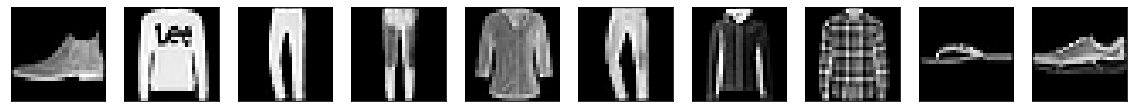

Reconstructed Test Dataset


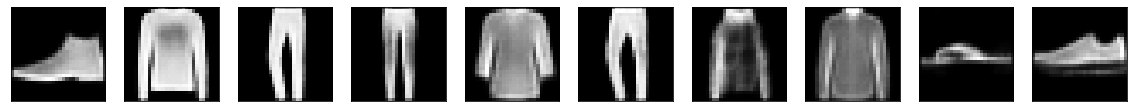

In [24]:
### READ ONLY

num_examples = 10
samples = next(iter(testloader))[0][:10].to(device)
vae_.eval()
with torch.no_grad():
    samples_recon, _, _ = vae_(samples)

samples = samples.permute((0, 2, 3, 1)).squeeze().cpu()
samples_recon = samples_recon.squeeze().cpu()
print('Original Test Dataset')
plotfigure(samples)
print('Reconstructed Test Dataset')
plotfigure(samples_recon)

We have come to the end of the assignment. We reconstructed the Fashion MNIST images using Variational Autoencoder. Lets generate a image using the decoder of VAE we just trained.

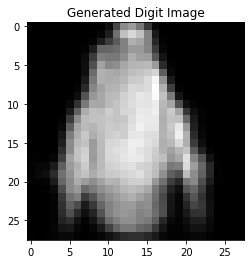

In [26]:
## READ ONLY
h = torch.randn((1, latent_dim), device=device)
vae_.eval()
with torch.no_grad():
    out = vae_.decoder(h)
    out = out.permute((0, 2, 3, 1)).squeeze().cpu()

plt.imshow(out, cmap='gray')
plt.title('Generated Digit Image')
plt.show()